# Диффузионные модели

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/puhsu/dl-hse/blob/main/week08-VAE-Diff/shw5/homework.ipynb)

#### Разработчик: Аким Котельников

План задания: пишем свою диффузионную модель и тестируем её на SwissRoll-ах (50% баллов), далее запускаем её на MNIST (20%), затем пишем DDIM и проверям его на MNIST (30%). Цель задания: разобраться как работают диффузионные модели, разобраться в формулах. При этом проблем с обучением моделей почти быть не должно. Формат: дозаполнить "todo".

### Импорты и SwissRoll-ы

In [ ]:
!wget --quiet --show-progress "https://raw.githubusercontent.com/puhsu/dl-hse/master/week08-VAE-Diff/shw5/utils.py"

utils.py.1          100%[===================>]   6,55K  --.-KB/s    in 0s      


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle

In [3]:
SEED = 777

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [4]:
from sklearn.datasets import make_circles, make_swiss_roll


def make_swiss_dataset(num_samples):
    X0, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X1, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X0 = X0[:, [0, 2]]
    X1 = X1[:, [0, 2]]
    X1 = -X1
    X, y = shuffle(
        np.concatenate([X0, X1], axis=0),
        np.concatenate([np.zeros(len(X0)), np.ones(len(X1))], axis=0),
        random_state=0,
    )
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    return X, y


X, y = make_swiss_dataset(2000)

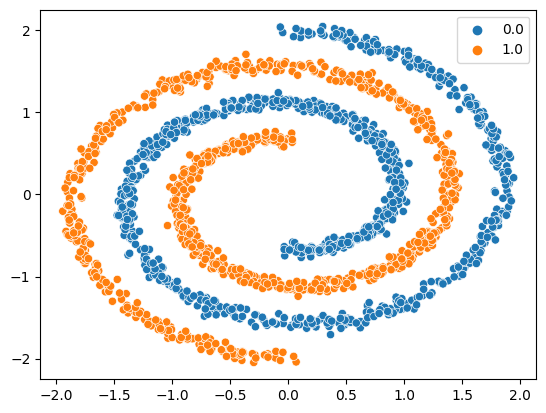

In [5]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

## DDPM (0.5 баллов)

В данной части вам предстоит написать собстевнную диффузионную модель (DDPM) и протестировать её на датасете выше.

### Напоминание

Напомним, что диффузионная модель состоит из прямого и обратного процесса. Прямой диффузионный процесс определяется как апостериорное распределение $q(x_{1:T}|x_0)$. Это распределение также является Марковской цепочкой, которая постепенно добавляет гауссовский шум к данному начальному объекту $x_0$. На каждом шаге шум добавляется с различной магнитудой, которая определяется расписанием дисперсий
 $\{\beta_1, ... \beta_T\}$. При правильном выборе расписания в пределе по числу шагов $T$ мы должны сойтись к шуму из $\mathcal{N}(0, I)$. В качестве распределений $q$ берут нормальные распределения:
$$
 q(x_t | x_{t - 1}) := \mathcal{N}(x_t; \sqrt{1 - \beta_t}x_{t - 1}, \beta_tI), \ \ \ \ \ \ \ q(x_{1:T}|x_0) = \prod_{t = 1}^T q(x_t | x_{t - 1})
$$

Теперь посмотрим со стороны обратного процесса. Обратный процесс расшумляет шум, пока не получится объект из изначального распределения. Таким образом, диффузионная модель - это вероятностная модель с латентными переменными вида $p_\theta(x_0) := \int p_\theta(x_{0:T}) dx_{1:T}$, где промежуточные состояния $x_1, ..., x_T$ соответствуют зашумленным объектам, a $x_0$ - объект из распределения. Совместное распределение $p_\theta(x_{0:T})$ называет обратным диффузионным процессом, который представляет собой Марковскую цепочку из гауссовских распределений $p_\theta(x_{i-1}|x_{i})$:

$$
p(x_{0:T}) = p(x_T) \prod_{t = 1}^Tp_{\theta}(x_{t-1}|x_t) \ \ \ \ \ \ \ \ \ p_\theta(x_{T})=\mathcal{N}(x_T | 0, I)
$$
$$
  p_{\theta}(x_{t - 1}|x_t):= \mathcal{N}(x_{t - 1}; \mu_{\theta}(x_t, t), \Sigma_{\theta}(x_t, t))
$$

Вернемся к распределению $q(x_t | x_{t - 1})$.  Для того чтобы получить $x_t$, придется итеративно получать $x_1, ..., x_{t - 1}$. Однако это можно сделать более эффективно благодаря нормальным распределениям. Для этого обозначим $\alpha_t := 1- \beta_t$ и $\bar{\alpha}_t:= \prod_{i = 1}^t\alpha_i$, тогда
$$
q(x_t | x_0) = \mathcal{N}(x_t;\sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t)I) \quad \quad \quad \quad \quad \quad (1)
$$

Затем модель можно обучать, оптимизируя отдельные члены суммы вариационной нижней оценки $\log p_{\theta}(x_0)$:
$$
L_{VLB} = \mathbb{E}_q [\underbrace{D_\text{KL}(q(\mathbf{x}_T |
\mathbf{x}_0) \parallel p_\theta(\mathbf{x}_T))}_{L_T} + + \sum_{t=2}^T
\underbrace{D_\text{KL}(q(\mathbf{x}_{t-1} | \mathbf{x}_t,
\mathbf{x}_0) \parallel p_\theta(\mathbf{x}_{t-1}
| \mathbf{x}_t))}_{L_{t-1}} \underbrace{- \log p_\theta(\mathbf{x}_0
| \mathbf{x}_1)}_{L_0}
$$

Для обучение нужно лишь выписать $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I}) $:

$$
    \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0 \ \ \ \ \ \ (2)
$$
$$
    \tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t  \quad \quad \quad \quad \quad \quad \quad (3)
$$


За подробностями читайте статью [Denoising Diffusion Probabilistic Models (Ho et al. 2020)](https://arxiv.org/abs/2006.11239).

Тем не менее в упомянутой статье было показано, что обучаясь на более простой лосс, получаются результаты лучше.  

Итак, заметим, что
$$
x_t(x_0, \epsilon) = \sqrt{\bar{\alpha}_t} x_0 +  \sqrt{1-\bar{\alpha}_t}\epsilon, \ \ \ \epsilon \sim \mathcal{N}(0, I) \quad \quad \quad \quad \quad \quad \quad (4)
$$

Тогда пускай наша модель с весами $\theta$ будет предсказывать $\epsilon$ из равенства выше, а именно обучаться, минимизируя данную функцию потерь:

$$L^{simple}_t = \mathbb{E}_{x_0, \epsilon, t}\bigg[ \|\epsilon - \epsilon_{\theta}(x_t, t)\|^2\bigg]$$

Именно этот лосс вы должны будете использовать.


Чтобы сэмплировать (обратный процесс), нам нужно получить $\mu_{\theta}(x_t, x_0)$ из $\epsilon_{\theta}(x_t, t)$. Для этого получите $\hat{x}_0(\epsilon_{\theta}, x_t)$ из уравнения (4) и подставьте его в равенство (2).

Переходим к заданию. Ниже будут представлены две вспомогательные функции, которые вам понадобятся.

In [6]:
# some functions you will need

import math


# utility function. basically, returns arr[timesteps], where timesteps are indices. (look at class Diffusion)
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D torch tensor for a batch of indices.
    :param arr: 1-D torch tensor.
    :param timesteps: a tensor of indices into torch array to extract.
    :param broadcast_shape: a larger shape of K dimensions with torch batch
                            dimension equal to torch length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where torch shape has K dims.
    """
    res = arr.to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)


# out beta_t. we use linear scheduler
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    scale = 1000 / num_diffusion_timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        return np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
    elif schedule_name == "quad":
        betas = torch.linspace(beta_start**0.5, beta_end**0.5, num_diffusion_timesteps) ** 2
        return betas.numpy()
    elif schedule_name == "sigmoid":
        betas = torch.linspace(-6, 6, num_diffusion_timesteps)
        betas = torch.sigmoid(betas) * (beta_end - beta_start) + beta_start
        return betas.numpy()
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

### Класс Diffusion (0.3 балла из 0.5 за DDPM)
Вам нужно дописать недостающие части ниже (помечены todo).

In [7]:
from tqdm import tqdm

class Diffusion:
    def __init__(
        self,
        *,
        betas: np.array,
        loss_type: str = "mse"
    ):
        """
        Class that simulates Diffusion process. Does not store model or optimizer.
        """

        betas = torch.from_numpy(betas).double()
        self.betas = betas
        assert len(betas.shape) == 1, "betas must be 1-D"
        assert (betas > 0).all() and (betas <= 1).all()

        self.num_timesteps = int(betas.shape[0])

        self.alphas = 1 - betas #todo
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0) #todo
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), self.alphas_cumprod[:-1]], dim=0)
        self.alphas_cumprod_next = torch.cat([self.alphas_cumprod[1:], torch.tensor([0.0]), ], dim=0)
        assert self.alphas_cumprod_prev.shape == (self.num_timesteps,)

        # calculations for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = self.alphas_cumprod.sqrt()
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)


        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod) * betas # todo, var from (3)

        # log calculation clipped because posterior variance is 0.
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]], dim=0)
        )
        self.posterior_mean_coef1 = torch.sqrt(self.alphas) * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod) # todo, coef of xt from (2)
        self.posterior_mean_coef2 = torch.sqrt(self.alphas_cumprod_prev) * betas / (1 - self.alphas_cumprod) # todo, coef of x0 from (2)

    def q_mean_variance(self, x0, t):
        """
        Get mean and variance of distribution q(x_t | x_0). Use equation (1).
        """

        mean = _extract_into_tensor(self.sqrt_alphas_cumprod, t, x0.shape) * x0 # todo
        variance = 1 - _extract_into_tensor(self.alphas_cumprod, t, x0.shape) # todo
        log_variance = torch.log(variance) # todo
        return mean, variance, log_variance

    def q_posterior_mean_variance(self, x_start, x_t, t):
        """
        Compute mean and variance of diffusion posterior q(x_{t-1} | x_t, x_0).
        Use equation (2) and (3).
        """
        assert x_start.shape == x_t.shape
        posterior_mean = _extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_t + \
                         _extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_start # todo
        posterior_variance = _extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = _extract_into_tensor(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse data for a given number of diffusion steps.
        Sample from q(x_t | x_0).
        """
        if noise is None:
            noise = torch.randn_like(x_start)
        return _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start + \
              _extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise # todo

    def p_mean_variance(self, model_output, x, t):
        """
        Apply model to get p(x_{t-1} | x_t). Use Equation (2) and plug in \hat{x}_0;
        """
        model_variance = torch.cat([self.posterior_variance[1:2], self.betas[1:]], dim=0)
        model_log_variance = torch.log(model_variance)
        model_variance = _extract_into_tensor(model_variance, t, x.shape)
        model_log_variance = _extract_into_tensor(model_log_variance, t, x.shape)

        pred_xstart = self._predict_xstart_from_eps(x, t, model_output)
        model_mean, _, _ =  self.q_posterior_mean_variance(pred_xstart, x, t)
        # print(model_mean.shape)
        return {
            "mean": model_mean,
            "variance": model_variance,
            "log_variance": model_log_variance,
            "pred_xstart": pred_xstart,
        }

    def _predict_xstart_from_eps(self, x_t, t, eps):
        """
        Get \hat{x0} from epsilon_{theta}. Use equation (4) to derive it.
        """

        return _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - \
               _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * eps

    def p_sample(self, model_output, x, t):
        """
        Sample from p(x_{t-1} | x_t).
        """
        out = self.p_mean_variance(model_output, x, t) # todo; get mean, variance of p(xt-1|xt)
        noise = torch.randn_like(x)
        nonzero_mask = (t[0] != 0).to(torch.int) # todo, no noise when t == 0
        # print(t, nonzero_mask.shape, out['mean'].shape)
        sample = out["mean"] + nonzero_mask * torch.exp(0.5 * out["log_variance"]) * noise
        return {"sample": sample}

    def p_sample_loop(self, model, shape, y_dist):
        """
        Samples a batch=shape[0] using diffusion model.
        """

        x = torch.randn(*shape, device=model.device)
        indices = list(range(self.num_timesteps))[::-1]

        y = torch.multinomial(
            y_dist,
            num_samples=shape[0],
            replacement=True
        ).to(x.device)

        for i in tqdm(indices):
            t = torch.tensor([i] * shape[0], device=x.device)
            with torch.no_grad():
                model_output = model(x, t, y)
                out = self.p_sample(
                    model_output,
                    x,
                    t
                )
                x = out["sample"]
        return x, y

    def train_loss(self, model, x0, y):
        """
        Calculates loss L^{simple}_t for the given model, x0.
        """
        t = torch.randint(0, self.num_timesteps, size=(x0.size(0),), device=x0.device)
        noise = torch.randn_like(x0)
        x_t = self.q_sample(x0, t, noise) # todo
        model_output = model(x_t, t, y) # todo
        loss = nn.MSELoss()(model_output, noise) # todo
        return loss

In [8]:
T = 100

diffusion = Diffusion(betas=get_named_beta_schedule("linear", T), loss_type="mse")

In [9]:
import matplotlib.pyplot as plt


def show_noising(diffusion, X, y):
    fig, axs = plt.subplots(1, 10, figsize=(40, 5))
    for i, t in enumerate(range(0, diffusion.num_timesteps, 10)):
        x = diffusion.q_sample(
            x_start=torch.from_numpy(X),
            t=torch.ones_like(torch.from_numpy(y)).long() * t,
        )

        sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y, ax=axs[i])
        axs[i].set(title=t)

Давайте посмотрим, как зашумляются наши данные с увеличением $t$. Как думаете, достаточно ли $T = 100$ или надо увеличить? Как можно понять, сколько достаточно? (не оценивается)

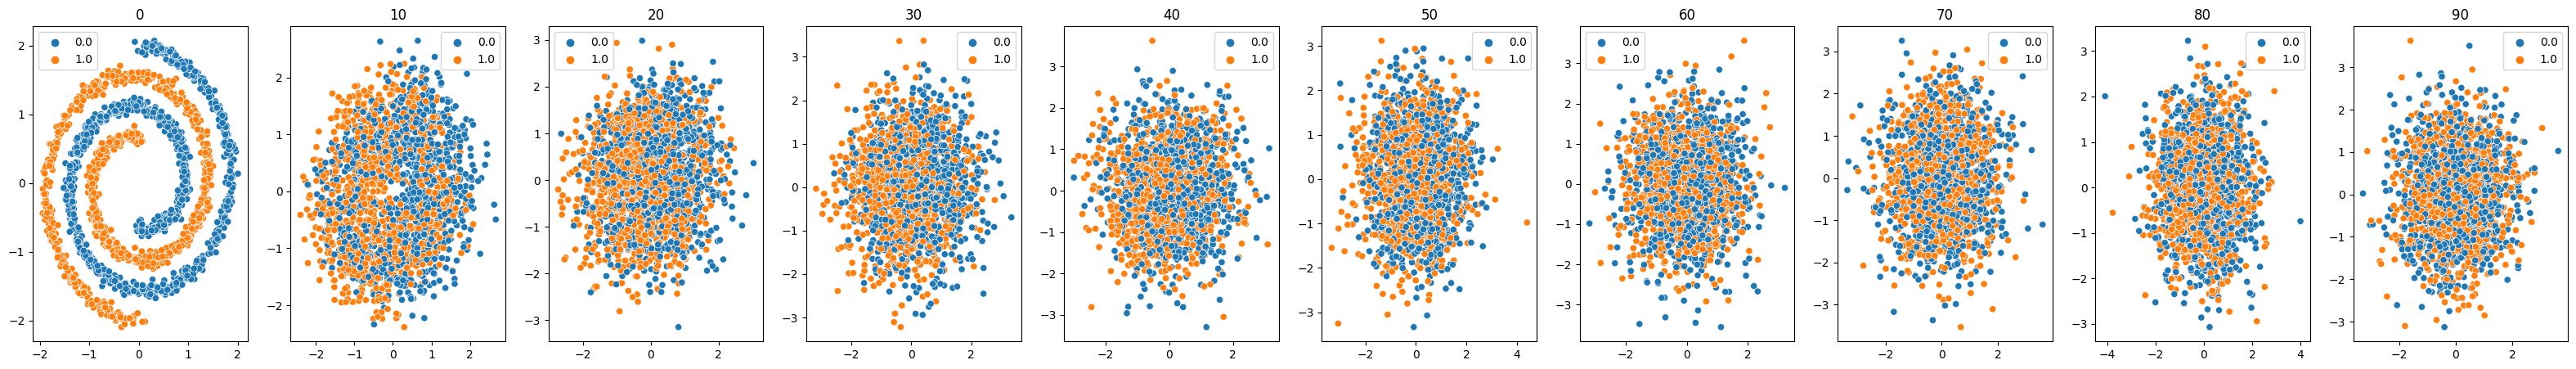

In [10]:
show_noising(diffusion, X, y)

Наверное понять, достаточно ли ста итераций можно исходя из распределения двух точек обоих классов на плоскости, оно должно быть похоже (исходя из теории) на нормальное распределение. Как мне кажется, у нас достаточно итераций

### Модель (0.1 балл из 0.5 за DDPM)

Тут мы реализуем модель с весами $\theta$, которая параметризует обратный процесс. Модель не должна быть сложной и большой. Достаточно только линейных слоев. Не забудьте учесть классы $y$ и шаги $t$. Модель предсказывает шум $\epsilon: \epsilon_{\theta}(x_t, t, y)$

In [11]:
from utils import sinusoidal_embedding
class DiffModel(nn.Module):
    def __init__(self, d_in, num_emb=2):
        super().__init__()

        self.hidden = 128
        self.x_proj = nn.Linear(d_in, self.hidden) # todo
        self.t_proj = nn.Embedding(T, self.hidden)
        self.t_proj.weight.data = sinusoidal_embedding(T, self.hidden)
        self.t_proj.requires_grad_(False) # todo
        self.y_embed = nn.Embedding(num_emb, self.hidden) # todo
        self.layers = nn.Sequential(
            nn.Linear(self.hidden, 2*self.hidden),
            nn.SiLU(),
            nn.Linear(2*self.hidden, 4*self.hidden),
            nn.SiLU(),
            nn.Linear(4*self.hidden, 4*self.hidden),
            nn.SiLU(),
            nn.Linear(4*self.hidden, 4*self.hidden),
            nn.SiLU(),
            nn.Linear(4*self.hidden, 2*self.hidden),
            nn.SiLU(),
            nn.Linear(2*self.hidden, self.hidden),
            nn.SiLU(),
            nn.Linear(self.hidden, d_in)
        ) # todo

    def forward(self, x, t, y):
        '''
        :x input, e.g. images
        :t 1d torch.LongTensor of timesteps
        :y 1d torch.LongTensor of class labels
        '''
        # todo
        x = self.x_proj(x)
        t = self.t_proj(t)
        y = self.y_embed(y)
        return self.layers(x + t + y)

In [12]:
model = DiffModel(d_in=2)
model.device = torch.device("cpu")  # достаточно cpu

### Обучение модели (0.1 балл из 0.5 за DDPM)

Наконец, обучим нашу модель. Ниже за вас написан класс `Trainer`, который хранит модель, диффузию и оптимайзер. Вам надо лишь дописать функцию `_run_step`

In [13]:
from copy import deepcopy
from tqdm import tqdm
import pandas as pd


class Trainer:
    def __init__(
        self,
        diffusion: Diffusion,
        model: nn.Module,
        train_iter,  # iterable that yields (x, y)
        lr: float,
        weight_decay: float,
        steps: int,
        device: torch.device = torch.device("cpu"),
    ):
        self.diffusion = diffusion

        self.train_iter = train_iter
        self.steps = steps
        self.init_lr = lr
        self.model = model
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.device = device
        self.log_every = 100
        self.print_every = 250

    def _anneal_lr(self, step: int):
        """
        Performs annealing of lr.
        """

        frac_done = step / self.steps
        lr = self.init_lr * (1 - frac_done)
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = lr

    def _run_step(self, x: torch.FloatTensor, y: torch.LongTensor):
        """
        A single training step.
        Calculates loss for a single batch.
        Then performs a single optimizer step and returns loss.
        """
        # todo
        self.optimizer.zero_grad(set_to_none=True)
        loss = self.diffusion.train_loss(self.model, x, y)
        loss.backward()
        self.optimizer.step()
        return loss

    def run_loop(self):
        """
        Training loop.
        """
        step = 0
        curr_loss_gauss = 0.0

        curr_count = 0
        while step < self.steps:
            x, y = next(self.train_iter)
            x, y = x.to(self.device), y.to(self.device)
            batch_loss = self._run_step(x, y)

            self._anneal_lr(step)

            curr_count += len(x)
            curr_loss_gauss += batch_loss.item() * len(x)

            if (step + 1) % self.log_every == 0:
                gloss = np.around(curr_loss_gauss / curr_count, 4)
                if (step + 1) % self.print_every == 0:
                    print(f"Step {(step + 1)}/{self.steps} Loss: {gloss}")
                curr_count = 0
                curr_loss_gauss = 0.0

            step += 1

Теперь обернем наши данные в `DataLoader`. Для этого за вас написан `FastTensorDataLoader`. Также у нас идет обучение не по эпохам, а по итерациям, поэтому нам нужен "бесконечный" итератор.

In [14]:
from utils import FastTensorDataLoader


def get_data_iter(X: np.array, y: np.array, batch_size: int = 512):
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).long()
    dataloader = FastTensorDataLoader(X, y, batch_size=batch_size, shuffle=True)
    while True:
        yield from dataloader


data_iter = get_data_iter(X, y)

In [15]:
# you can change hyperparameters
trainer = Trainer(diffusion, model, train_iter=data_iter, lr=0.01, weight_decay=0.0, steps=6000)

In [16]:
trainer.run_loop()  # < 1min

Step 500/6000 Loss: 0.2858
Step 1000/6000 Loss: 0.2627
Step 1500/6000 Loss: 0.2521
Step 2000/6000 Loss: 0.2503
Step 2500/6000 Loss: 0.2493
Step 3000/6000 Loss: 0.2426
Step 3500/6000 Loss: 0.2455
Step 4000/6000 Loss: 0.2409
Step 4500/6000 Loss: 0.2348
Step 5000/6000 Loss: 0.2298
Step 5500/6000 Loss: 0.2306
Step 6000/6000 Loss: 0.2229


Теперь насэмплируем данные из нашей модели

In [17]:
from typing import List, Tuple


def sample_synthetic(
    diffusion: Diffusion,
    model: nn.Module,
    num_samples: int,
    batch: int = 1000,
    shape: Tuple = (2,),
    y_dist: List[int] = [0.5, 0.5],
    ddim: bool = False,
):
    sample_func = diffusion.p_sample_loop
    if ddim:  # for the last task
        sample_func = diffusion.ddim_sample
    res_x = []
    res_y = []
    num_sampled = 0
    while num_sampled < num_samples:
        x, y = diffusion.p_sample_loop(model, shape=(batch, *shape), y_dist=torch.tensor(y_dist))
        res_x.append(x.cpu())
        res_y.append(y.cpu())
        num_sampled += batch

    res_x = torch.cat(res_x, dim=0)
    res_y = torch.cat(res_y, dim=0)
    return res_x[:num_samples], res_y[:num_samples]

In [18]:
Xs, ys = sample_synthetic(diffusion, model, 1000)

100%|██████████| 100/100 [00:02<00:00, 34.81it/s]


<Axes: >

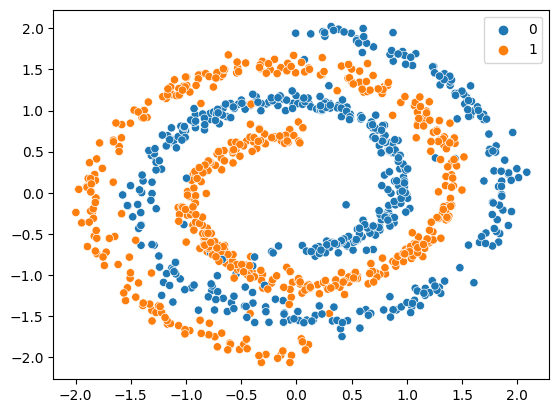

In [19]:
sns.scatterplot(x=Xs[:, 0], y=Xs[:, 1], hue=ys)

Оцените на глаз, что получилось (должно быть неплохо). Как можно численно оценить качество насэмплированных данных (именно этих данных)?  Пункт не оценивается.

Покажете процесс расшумления аналагично тому, как мы это делали для прямого процесса

In [ ]:
# TODO сделать визуализацию

## MNIST (0.2 балла)

Перейдём к обучению диффузионной модели на MNIST. За вас уже написана архитектура модели. В данной задаче надо лишь получить относительно *хороший* результат на датасете, используя класс `Diffusion`, а также посмотреть на разные расписание шума.

In [20]:
from torch.utils.data import DataLoader
class InfiniteDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Initialize an iterator over the dataset.
        self.dataset_iterator = super().__iter__()

    def __iter__(self):
        return self

    def __next__(self):
        try:
            batch = next(self.dataset_iterator)
        except StopIteration:
            # Dataset exhausted, use a new fresh iterator.
            self.dataset_iterator = super().__iter__()
            batch = next(self.dataset_iterator)
        return batch

In [21]:
from torch.utils.data import DataLoader
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import Compose, Lambda, Normalize, ToTensor

transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

dataset = MNIST("./datasets", download=True, train=True, transform=transform)
loader = InfiniteDataLoader(dataset, 512, shuffle=True)

In [22]:
def show_images(images, ys, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()
        ys = ys.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                plt.title(f"{int(ys[idx])}")
                plt.tick_params(bottom=False, labelbottom=False)
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()


def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0][:16], batch[1][:16], "Images in the first batch")
        break

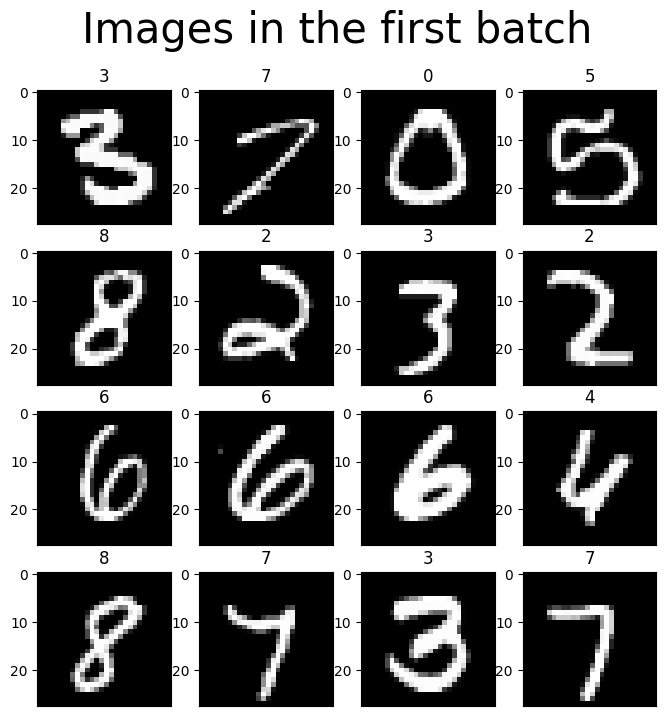

In [23]:
show_first_batch(loader)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	Tesla T4


In [25]:
from utils import MyUNet

model_mnist = MyUNet().to(device)
model_mnist.device = device

### Смотрим на расписание шума

Прежде чем начать, постройте на одной картинке графики $\sqrt{\bar{\alpha_t}}$ (относительно $t$) для различных расписаний (linear, quad, sigmoid). Объясните, чем они отличаются. Чтобы лучше это понять визуализируйте зашумление картинок (функция `show_noising_mnist`). Советую выбрать $T = 1000$ (классический выбор, если домен -- картинки). Данный пункт оценивается.

In [26]:
def get_alpha_bar(betas):
    for beta in betas:
        schedule = get_named_beta_schedule(beta, 1000)
        plt.plot(np.arange(1000), schedule, label=beta)
    plt.legend()
    plt.show()

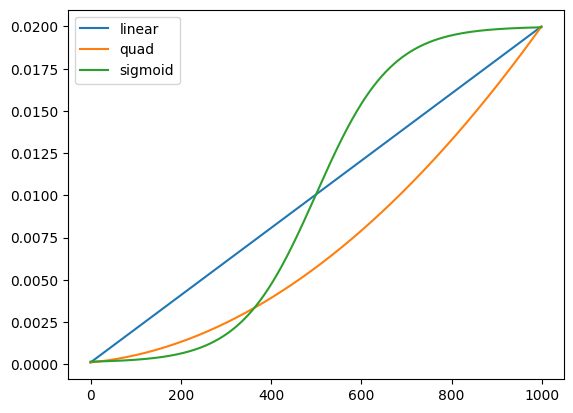

In [27]:
ts = range(1000)

# your plots here

get_alpha_bar(["linear", "quad", "sigmoid"])

In [28]:
# almost the same as in the task with SwissRolls

def show_noising_mnist(diffusion, img, name):
    fig, axs = plt.subplots(1, 10, figsize=(40, 5))
    for i, t in enumerate(range(0, diffusion.num_timesteps, 100)):
        x = diffusion.q_sample(
            x_start=img,
            t=torch.tensor([t])
        )

        axs[i].imshow(x[0], cmap='gray')
        axs[i].set(title=f"{name} with {t} iterations of noise")

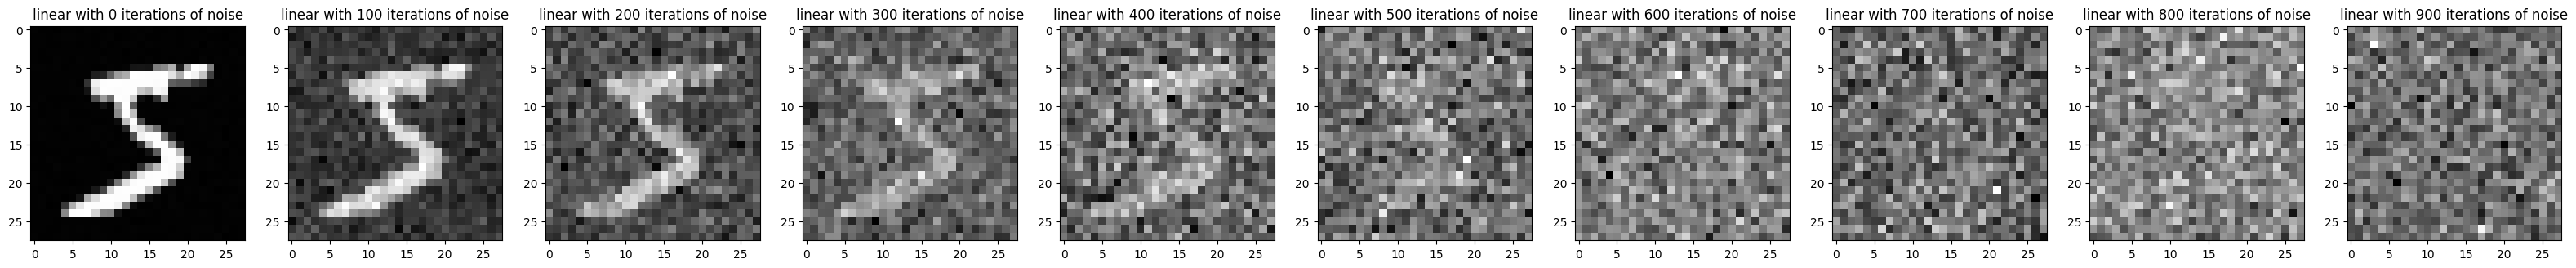

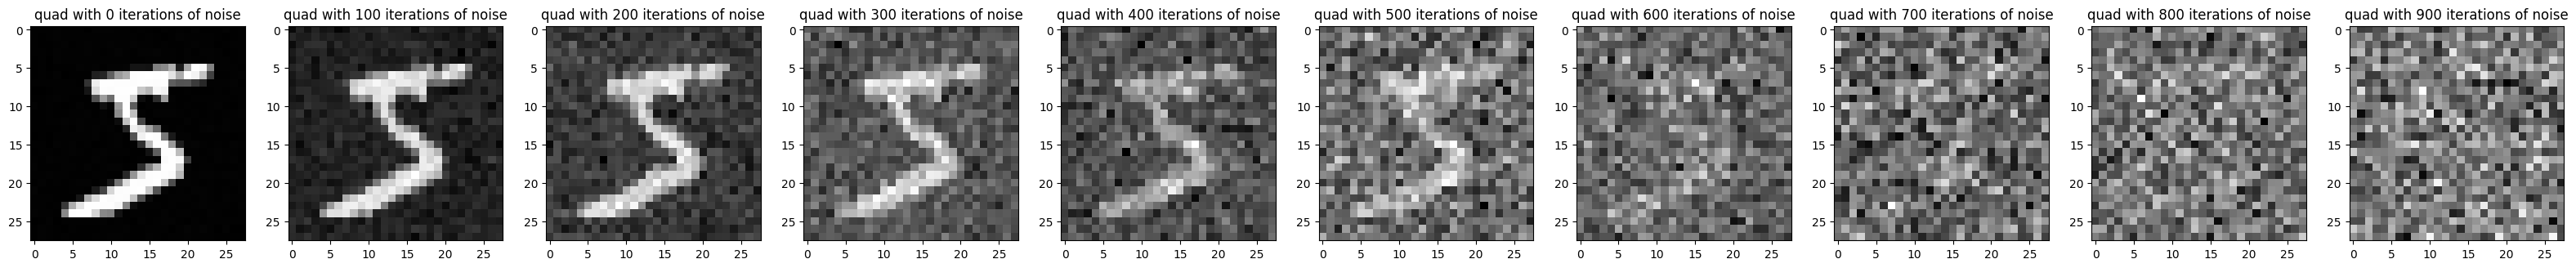

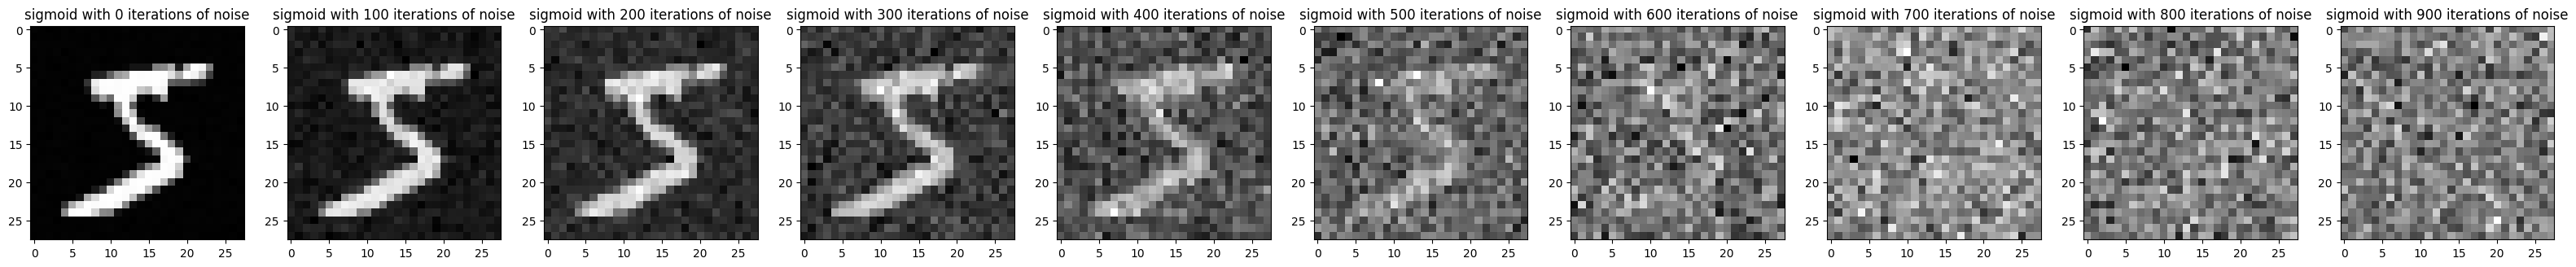

In [29]:
for sch in ["linear", "quad", "sigmoid"]:
    diffusion_temp = Diffusion(betas=get_named_beta_schedule(sch, 1000), loss_type="mse")
    show_noising_mnist(diffusion_temp, dataset[0][0], sch)

Понятно, что все три расписания отличаются тем, с какой силой они зашумляют исходное изображение. Понятно так же, что линейный шедулер делает это сильнее всего. Это понятно из формул и из графика где есть все три шедулера. Также кажется, что квадратичный слабее всех воздействует на картинку в силу того что шумы маленькие при процессе зашумления

### Обучаем

In [30]:
scheduler = "quad" # choose your pokemon
# Попробовал разных покемонов, оставил лучшего

diffusion_mnist = Diffusion(
    betas=get_named_beta_schedule(scheduler, 1000),
    loss_type="mse"
)

# feel free to change hyperaparameters

trainer_mnist = Trainer(
    diffusion_mnist,
    model_mnist,
    train_iter=loader,
    lr=0.001,
    steps=3000,
    weight_decay=0.0,
    device=device,
)

In [31]:
trainer_mnist.run_loop()  # <15min on 2080Ti for the author's solution


Step 500/3000 Loss: 0.0934
Step 1000/3000 Loss: 0.0764
Step 1500/3000 Loss: 0.0692
Step 2000/3000 Loss: 0.0649
Step 2500/3000 Loss: 0.0625
Step 3000/3000 Loss: 0.0618


In [32]:
Xs, ys = sample_synthetic(
    diffusion_mnist,
    model_mnist,
    num_samples=16,
    batch=16,
    shape=(1, 28, 28),
    y_dist=[0.1 for _ in range(10)],
)

100%|██████████| 1000/1000 [00:08<00:00, 121.49it/s]


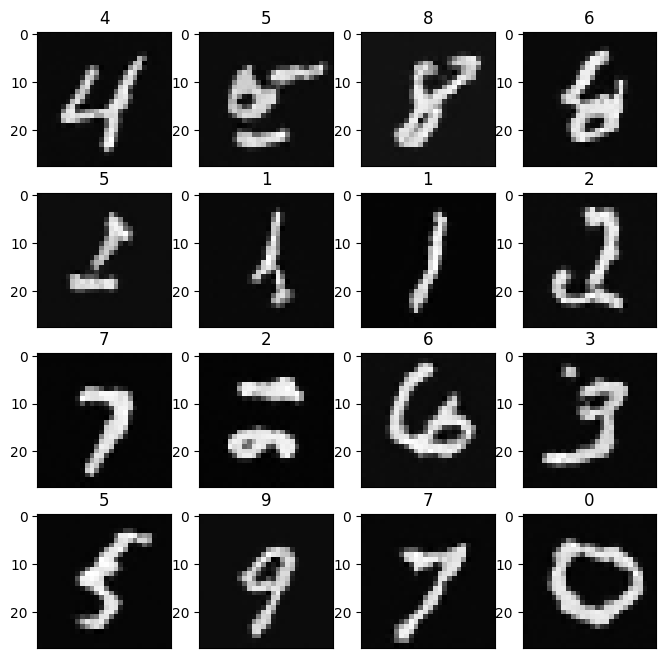

In [33]:
show_images(Xs, ys)

Оцените качество насэмплированных картинок.

Сначала учил 1000 итераций, этого объективно не хватало, сейчас же получилось все как надо, в целом из 16 картинок адекватными получились 11. Еще несколько чуть-чуть плохие, но в целом нормально вроде.

## DDIM (0.3 балла)

**ВАЖНО:** В данном задании используется нотация из оригинальной статьи. Оно отличается от нотации выше. А именно, считайте, что ниже $\alpha_t := \sqrt{\bar{\alpha}_t}$. Также $\sigma_t$ ниже тоже отличается (о том, что это, будет написано дальше).

В данной задаче вам предстоит реализовать DDIM сэмплирования. Подробнее читайте тут: [Denoising Diffusion Implicit Models, Song et al., 2020](https://arxiv.org/abs/2010.02502).

Давайте вкратце опишем, в чем смысл. Идея следущая: давайте изменим прямой диффузионный процесс так, чтобы используя предобученную DDPM, приближать новый обратный процесс за меньшее число шагов. В данном заданее мы не будем ускорять процесс сэмплирования, но реализуем DDIM.

Чтобы не обучать новую модель, нам нужен прямой диффузионный процесс, у которого будет такая же функция потерь (MSE на шум), а обратный процесс все еще останется марковским. Оказалось, что существует целое семейство немарковских прямых процессов, удовлетворяющих этим требования. Это семейство имеет следующий вид (индуцируемое $\sigma \in \mathbb{R}^T$):

![ddim](https://i.imgur.com/lB2KaOR.png)

Распределения выше были выбраны так, чтобы $q(x_t | x_0)$ оставалось таким же, как раньше. Это можно проверить, используя формулу Байеса и свойства нормальных распределений.

Тогда обратный пройесс можно переписать как $q_{\sigma}(x_{t-1}|x_t, \hat{x}_{0}(x_t))$ или же:

\begin{equation*}
    x_{t-1} = \sqrt{\alpha_{t-1}} \underbrace{\left(\frac{x_t - \sqrt{1 - \alpha_t} \epsilon_\theta^{(t)}(x_t)}{\sqrt{\alpha_t}}\right)}_{\text{`` predicted } x_0 \text{''}} + \underbrace{\sqrt{1 - \alpha_{t-1} - \sigma_t^2} \cdot \epsilon_\theta^{(t)}(x_t)}_{\text{``direction pointing to } x_t \text{''}} + \underbrace{\sigma_t \epsilon_t}_{\text{random noise}}  \quad \quad \quad \quad \quad \quad (8)
\end{equation*}

Теперь давайте скажем, что $\sigma_t(\eta) = \eta\sqrt{(1 - \alpha_{t - 1})(1 - \alpha_t)}\sqrt{1 - \alpha_t / \alpha_{t - 1}}$, тогда при $\eta = 1$ равенство (8) превращается в DDPM сэмплирование. При $\eta = 0$ у нас $\sigma_t = 0$ и пропадает третья компонента стохастичности, что и называется DDIM сэмплирование. Таким образом, у нас есть детерминистичный процесс сэмплирования: при заданном начальном латенте мы всегда насэмлируем один и тот же $x_0$. Также можно достичь ускорения сэмплирования, выбирая лишь подмножество шагов $0 \leq \tau_1 \leq ... \leq \tau_S \leq T, \ \ \ S < T$ и сэмплируя с помощью DDIM по ним.

Поскольку процесс детерминистичный, то мы можем инвертировать равенство (8) и получить $x_t(x_{t - 1})$, то есть процесс зашумления (reversed DDIM).

Все вышеописанное может быть полезно для осмысленных интерполяций в латентом пространстве (взяли две картинки, сделали обратный DDIM, получили два шума, как-то их проинтерполировали, расшумили DDIM, получили что-то среднее).


Итак, ниже вам придется реализовать прямой и обратный DDIM. Однако мы не будем интерполировать латенты, а лишь зашумим-расшумим наши картинки. Важно отметить, что нам не нужно переучивать модель, чтобы пользоваться DDIM.

In [52]:
class DiffusionWithDDIM(Diffusion):
    def __init__(self, *args, **kwargs):
        super(DiffusionWithDDIM, self).__init__(*args, **kwargs)

    @torch.no_grad()
    def ddim_step(
        self,
        model_out: torch.FloatTensor,
        x: torch.FloatTensor,
        t: torch.LongTensor,
        eta: float = 0.0
    ):
        """
        Performs ddim step. Use equation (8).
        """

        eps = model_out

        alpha_bar = _extract_into_tensor(self.alphas_cumprod, t, x.shape) # todo
        alpha_bar_prev = _extract_into_tensor(self.alphas_cumprod_prev, t, x.shape) # todo
        sigma = eta * torch.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar)) * torch.sqrt(1 - alpha_bar / alpha_bar_prev) # todo

        noise = torch.randn_like(x)
        pred_xstart = self._predict_xstart_from_eps(x, t, eps)
        mean_pred = torch.sqrt(alpha_bar_prev) * pred_xstart + torch.sqrt(1 - alpha_bar_prev - sigma**2) * (x - torch.sqrt(alpha_bar) * pred_xstart) / torch.sqrt(1 - alpha_bar) # todo
        nonzero_mask = (t[0] != 0).to(torch.int) # todo, no noise when t == 0
        sample = mean_pred + nonzero_mask * sigma * noise

        return sample

    @torch.no_grad()
    def ddim_sample(
        self,
        model: nn.Module,
        shape: Tuple,
        y_dist: torch.FloatTensor,
        y: torch.LongTensor = None,
        noise: torch.FloatTensor = None,
    ):
        """
        Performs ddim sampling.
        """
        if noise is None:
            x = torch.randn(shape)
        else:
            x = noise

        b = x.shape[0]
        if y is None:
            y = torch.multinomial(
                y_dist,
                num_samples=shape[0],
                replacement=True
            )

        device = x.device
        for t in reversed(range(self.num_timesteps)):
            print(f'Sample timestep {t:4d}', end='\r')
            t_array = (torch.ones(b, device=device) * t).long()
            model_out = model(x, t_array, y)
            x = self.ddim_step(
                model_out,
                x,
                t_array
            )
        print()
        return x, None

    @torch.no_grad()
    def ddim_reverse_step(
        self,
        model_out,
        x,
        t,
        eta=0.0 # dummy
    ):
        """
        Performs DDIM reverse step, i.e. xt from x_{t-1}. Use equation (8) to derive.
        """
        assert eta == 0.0, "Eta must be zero."

        eps = model_out

        alpha_bar_next = _extract_into_tensor(self.alphas_cumprod_next, t, x.shape) # todo
        alpha_bar_prev = _extract_into_tensor(self.alphas_cumprod, t, x.shape)
        # pred_xstart = self._predict_xstart_from_eps(x, t, eps)
        mean_pred = x / torch.sqrt(alpha_bar_prev) * torch.sqrt(alpha_bar_next) + (torch.sqrt(1 - alpha_bar_next) - \
                    torch.sqrt(alpha_bar_next / alpha_bar_prev) * torch.sqrt(1 - alpha_bar_prev)) * eps # todo

        return mean_pred


    @torch.no_grad()
    def ddim_reverse_sample(
        self,
        model: nn.Module,
        x: torch.FloatTensor,
        y: torch.LongTensor,
    ):
        device = x.device
        # todo
        indices = list(range(self.num_timesteps))
        for i in indices:
            t = torch.ones_like(y, device=device) * i
            x = self.ddim_reverse_step(model(x, t, y), x, t)

        return x

In [53]:
diffusion_ddim = DiffusionWithDDIM(betas=get_named_beta_schedule(scheduler, 1000), loss_type="mse")

Теперь развернем картинки из прошлого задания и получим латенты $x_T$. И насэмплируем из этих латентов с помощью DDIM.

In [54]:
eps_reveresed = diffusion_ddim.ddim_reverse_sample(model_mnist, Xs.to(device), ys.to(device))

In [55]:
Xs_new, _ = diffusion_ddim.ddim_sample(
    model_mnist,
    shape=(1, 28, 28),
    y_dist=torch.tensor([0.1] * 10),
    noise=eps_reveresed.to(model_mnist.device),
    y=ys.to(model_mnist.device),
)

Sample timestep    0


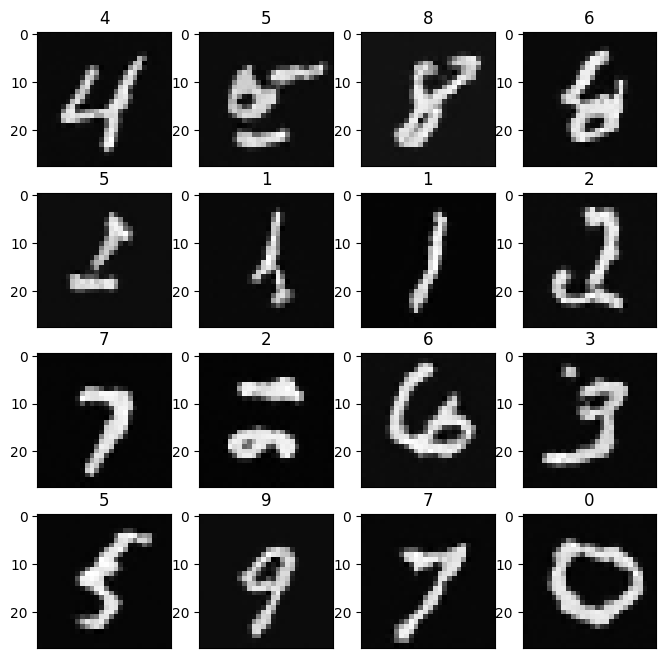

In [56]:
show_images(Xs, ys)

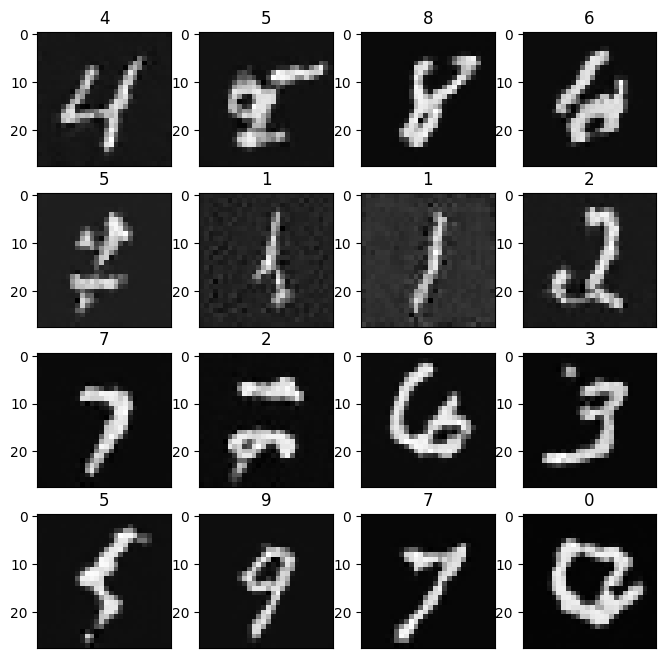

In [57]:
show_images(Xs_new, ys)

Оцените полученные сэмплы. Идеально ли они восстановились? Если нет, то почему? Пункт оценивается.